# Projet 4 - prédiction du retard d'avions
# Première partie : nettoyage et exploration
Les fichiers de données doivent se trouver dans un sous-répertoire `transtats`.

## I. Initialisation

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_profiling
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.holiday import USFederalHolidayCalendar
from scipy import stats
import seaborn as sns
import sys

CSV_FILES = [f"transtats/2016_{m:02}.csv" for m in range(1, 13)]

OUTPUT_FILE = 'flights.csv'

# Taille des figures créées par pyplot 
FIG_SIZE = (12, 4)

# Désactiver l'appel à ProfileReport(), qui est lent
DISABLE_PROFILER = False

# Effacer les entrées avec un retard négative (i.e. les vols en avance) 
REMOVE_NEGATIVE_DELAYS = False 

# Activer la sauvegarde des données après nettoyage et enrichissement
EXPORT_DATA = True 

SNS_MEAN_MARKER = {
    'marker': '.',
    'markerfacecolor': 'black',
    'markeredgecolor': 'black'
}

register_matplotlib_converters()

print(f"Version de matplotlib : {matplotlib.__version__}")
print(f"Version de pandas : {pd.__version__}")
print(f"Version de Python : {sys.version}")

# À essayer :
# sns.set(style="darkgrid")

Version de matplotlib : 3.0.3
Version de pandas : 0.24.2
Version de Python : 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [2]:
# Colonnes à charger
cols = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
    'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST',
    'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY',
    'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'DISTANCE'
]
# Chargement de tous les fichiers
df = pd.concat((pd.read_csv(f, usecols=cols) for f in CSV_FILES),
               ignore_index=True)
# Suppression de la dernière colonne qui ne contient pas de données
df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
print(f"Taille des données : {df.shape}")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DtypeWarning: Columns (1,3,4,10,29,31,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


Taille des données : (5635984, 18)


In [3]:
def rotate_xlabels(axes):
    """Affiche verticalement les labels de l'axe des abscisses."""
    for item in axes.get_xticklabels():
        item.set_rotation(90)

## II. Examen initial

### Aperçu de la structure des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635984 entries, 0 to 5635983
Data columns (total 18 columns):
QUARTER             object
MONTH               int64
DAY_OF_MONTH        object
DAY_OF_WEEK         object
FL_DATE             object
UNIQUE_CARRIER      object
FL_NUM              object
ORIGIN              object
ORIGIN_STATE_ABR    object
DEST                object
DEST_STATE_ABR      object
CRS_DEP_TIME        object
DEP_DELAY           object
CRS_ARR_TIME        object
ARR_DELAY           object
CANCELLED           float64
DIVERTED            float64
CRS_ELAPSED_TIME    float64
dtypes: float64(3), int64(1), object(14)
memory usage: 774.0+ MB


In [5]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME
0,1,1,6,3,2016-01-06,AA,43,DFW,TX,DTW,MI,1100,-3,1438,-6,0.0,0.0,158.0
1,1,1,7,4,2016-01-07,AA,43,DFW,TX,DTW,MI,1100,-4,1438,-12,0.0,0.0,158.0
2,1,1,8,5,2016-01-08,AA,43,DFW,TX,DTW,MI,1100,-5,1438,7,0.0,0.0,158.0
3,1,1,9,6,2016-01-09,AA,43,DFW,TX,DTW,MI,1100,2,1438,-5,0.0,0.0,158.0
4,1,1,10,7,2016-01-10,AA,43,DFW,TX,DTW,MI,1100,100,1438,113,0.0,0.0,158.0


### Vérification de la cohérence des données

In [6]:
cols = ['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER']
for c in cols:
    print(c, ":", df[c].unique())

QUARTER : [1 2 '2' 'EV' '1' 3 4]
MONTH : [    1     2     3     4 20366     5     6     7     8     9    10    11
    12]
DAY_OF_MONTH : [6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 1 2 3 4 5 '2' '3' '1' 'EV' '6' '15' '13' '12' '20' '8' '29' '31' '11'
 '21' '17' '28' '19' '27' '25' '10' '24' '22' '14' '18' '26' '7' '5' '4'
 '9' '23' '16' '30']
DAY_OF_WEEK : [3 4 5 6 7 1 2 '6' '7' '5' 'N707EV' '2' '4' '1' '3']
UNIQUE_CARRIER : ['AA' 'AS' 'B6' 'DL' 'F9' 'HA' 'NK' 'EV' 'OO' 'UA' 'VX' 'WN' '10397']


On observe la présence d'entrées avec des valeurs et des types manifestement incorrects. Nous devrons vérifier après les conversions de types et le nettoyage si elles sont encore présentes.

### Génération d'un rapport par `ProfileReport`

In [7]:
if DISABLE_PROFILER:
    print("ProfileReport désactivé.") 
else:
    pandas_profiling.ProfileReport(df)

## III. Nettoyage des données

### Délai manquant

In [8]:
mask = df['ARR_DELAY'].isna() 
print(f"Nombre de vols avec délai manquant : {len(df[mask])}")
mask = mask & (df['CANCELLED'] != 1) & (df['DIVERTED'] != 1)
print(f"Nombre de vols avec délai manquant inexpliqué : {len(df[mask])}")

Nombre de vols avec délai manquant : 79781
Nombre de vols avec délai manquant inexpliqué : 3


Nous pouvons maintenant supprimer les colonnes `CANCELLED` et `DIVERTED`.

In [9]:
del_cols = ['CANCELLED', 'DIVERTED']
df.drop(columns=del_cols, inplace=True, errors='ignore')
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5635984, 16)


### Colonnes avec valeurs manquantes

In [10]:
na_count = df.isna().sum(axis=0)
na_count[na_count != 0]

DEST                    1
DEST_STATE_ABR          1
DEP_DELAY           63539
CRS_ARR_TIME            3
ARR_DELAY           79781
CRS_ELAPSED_TIME       10
dtype: int64

Étant donné la faible proportion de valeurs manquantes, nous effaçons les lignes concernées.

In [11]:
df.dropna(axis=0, how='any', inplace=True)
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5556202, 16)


### Conversion des colonnes numériques

In [12]:
numeric_cols = [
    "QUARTER", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "FL_NUM",
    "CRS_DEP_TIME", "DEP_DELAY", "CRS_ARR_TIME", "ARR_DELAY",
    "CRS_ELAPSED_TIME"
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(axis=0, how='any', inplace=True)  # suppression des erreurs
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5556197, 16)


In [13]:
int_cols = [
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME',
    'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME'
]
df[int_cols] = df[int_cols].astype(int, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556197 entries, 0 to 5635983
Data columns (total 16 columns):
QUARTER             int32
MONTH               int32
DAY_OF_MONTH        int32
DAY_OF_WEEK         int32
FL_DATE             object
UNIQUE_CARRIER      object
FL_NUM              float64
ORIGIN              object
ORIGIN_STATE_ABR    object
DEST                object
DEST_STATE_ABR      object
CRS_DEP_TIME        int32
DEP_DELAY           int32
CRS_ARR_TIME        int32
ARR_DELAY           int32
CRS_ELAPSED_TIME    int32
dtypes: float64(1), int32(9), object(6)
memory usage: 529.9+ MB


### Deuxième vérification de la cohérence des données

In [14]:
cols = ['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER']
for c in cols:
    print(c, ":", df[c].unique())

QUARTER : [1 2 3 4]
MONTH : [ 1  2  3  4  5  6  7  8  9 10 11 12]
DAY_OF_MONTH : [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31  1  2  3  4  5]
DAY_OF_WEEK : [3 4 5 6 7 1 2]
UNIQUE_CARRIER : ['AA' 'AS' 'B6' 'DL' 'F9' 'HA' 'NK' 'EV' 'OO' 'UA' 'VX' 'WN']


Les valeurs aberrantes ont disparu.

### Standardisation de la représentation de minuit

In [15]:
df.loc[df['CRS_ARR_TIME'] >= 2400, 'CRS_ARR_TIME'].value_counts()

2400    15
Name: CRS_ARR_TIME, dtype: int64

In [16]:
df.loc[df['CRS_ARR_TIME'] < 100, 'CRS_ARR_TIME'].value_counts()

5     5619
15    4465
55    3984
25    3757
30    3687
20    3587
10    3566
50    2662
45    2348
35    2345
40    2281
6     1631
1     1489
26    1393
9     1370
4     1337
8     1326
13    1306
27    1288
18    1248
11    1207
12    1196
2     1171
16    1162
14    1137
29    1081
19    1072
21     986
23     967
59     960
3      951
39     907
22     849
28     818
7      786
44     756
42     744
31     738
24     728
33     712
54     686
32     675
58     667
37     654
41     640
53     599
43     598
34     549
48     544
17     537
51     536
46     526
47     518
49     517
57     513
36     498
38     491
52     488
56     433
Name: CRS_ARR_TIME, dtype: int64

Conclusion : la représentation de minuit par h = 0 est bien plus courante que par h = 24.

In [17]:
mask = (df['CRS_ARR_TIME'] == 2400)
df.loc[mask, 'CRS_ARR_TIME'] = 0
df.loc[df['CRS_ARR_TIME'] >= 2400, 'CRS_ARR_TIME'].value_counts()

Series([], Name: CRS_ARR_TIME, dtype: int64)

### Conversion des dates

In [18]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'],
                               format='%Y-%m-%d',
                               errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556197 entries, 0 to 5635983
Data columns (total 16 columns):
QUARTER             int32
MONTH               int32
DAY_OF_MONTH        int32
DAY_OF_WEEK         int32
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
FL_NUM              float64
ORIGIN              object
ORIGIN_STATE_ABR    object
DEST                object
DEST_STATE_ABR      object
CRS_DEP_TIME        int32
DEP_DELAY           int32
CRS_ARR_TIME        int32
ARR_DELAY           int32
CRS_ELAPSED_TIME    int32
dtypes: datetime64[ns](1), float64(1), int32(9), object(5)
memory usage: 529.9+ MB


### Suppression (optionnelle) des vols en avance
Notre objectif étant de prédire des retards de vols (au sens courant, pas au sens algébrique), nous éliminons de notre base les vols arrivés en avance.

In [19]:
mask = df['ARR_DELAY'] < 0
total = sum(mask)
print(f"Nb de vols arrivés en avance : {total} ({total/len(mask)*100:0.2f}%)")
if REMOVE_NEGATIVE_DELAYS:
    df = df[~mask]
else:
    print("Effacement des vols en avance désactivé.")
print(f"Nouvelle taille des données : {df.shape}")

Nb de vols arrivés en avance : 3549696 (63.89%)
Effacement des vols en avance désactivé.
Nouvelle taille des données : (5556197, 16)


### Réduction du nombre de colonnes (section devenue inutile)
Lors d'une deuxième itération, nous avons modifié le code de chargement pour n'inclure qu'un petit nombre de colonnes utiles. La présente section n'a alors plus d'effet, mais nous la conservons pour montrer notre cheminement.

Les colonnes CANCELLATION_CODE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, FIRST_DEP_TIME, TOTAL_ADD_GTIME, LONGEST_ADD_GTIME ne contiennent pas assez de données pour être utiles.
Nous les supprimons donc.

In [20]:
del_cols = [
    'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
    'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME',
    'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME'
]
df.drop(columns=del_cols, inplace=True, errors='ignore')
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5556197, 16)


Nous effaçons également les colonnes suivantes qui nous semblent a priori inutiles.

Cette liste sera susceptible d'être modifiée ultérieurement.

In [21]:
del_cols = [
    'YEAR',  # disponible dans la date
    'AIRLINE_ID',  # équivalent au code à 2 lettres
    'CARRIER',  # nous conservons le code unique
    'TAIL_NUM',  # pas observable
    'ORIGIN_AIRPORT_ID',  # nous utilisons le code à 3 lettres
    'ORIGIN_AIRPORT_SEQ_ID',  # idem
    'ORIGIN_CITY_MARKET_ID',  # moins riche que le code d'aéroport
    'ORIGIN_CITY_NAME',  # nous utilisons la version courte
    'ORIGIN_STATE_FIPS',  # nous conservons le code court de l'état
    'ORIGIN_STATE_NM',  # idem
    'ORIGIN_WAC',  # redondant
    'DEST_AIRPORT_ID',  # nous utilisons le code à 3 lettres
    'DEST_AIRPORT_SEQ_ID',  # idem
    'DEST_CITY_MARKET_ID',  # moins riche que le code d'aéroport
    'DEST_CITY_NAME',  # nous utilisons la version courte
    'DEST_STATE_FIPS',  # nous conservons le code court de l'état
    'DEST_STATE_NM',  # idem
    'DEST_WAC',  # redondant
    'DEP_TIME',  # inconnu à l'avance
#    'DEP_DELAY',  # inconnu à l'avance
    'DEP_DELAY_NEW',  # inconnu à l'avance
    'DEP_DEL15',  # inconnue à l'avance
    'DEP_DELAY_GROUP',  # redondant
    'DEP_TIME_BLK',  # redondant
    'TAXI_OUT',  # inconnu à l'avance
    'WHEELS_OFF',  # idem
    'WHEELS_ON', # inutile
    'TAXI_IN', # inutile
    'ARR_TIME',  # nous utilisons ARR_DELAY
    'ARR_DELAY_NEW',  # redondant
    'ARR_DEL15',  # redondant
    'ARR_DELAY_GROUP',  # redondant
    'ARR_TIME_BLK',  # redondant
    'CANCELLATION_CODE',  # inutile pour ce projet
    'ACTUAL_ELAPSED_TIME',  # redondant
    'AIR_TIME',  # pas observable à l'avance
    'FLIGHTS',  # pas utile
    'DISTANCE_GROUP',  # redondant
    'CARRIER_DELAY',  # la nature du délai ne nous intéresse pas
    'WEATHER_DELAY',  # idem
    'NAS_DELAY',  # idem
    'SECURITY_DELAY',  # idem
    'LATE_AIRCRAFT_DELAY',  # idem
    'FIRST_DEP_TIME',  # inutile pour ce projet
    'TOTAL_ADD_GTIME',  # inutile pour ce projet
    'LONGEST_ADD_GTIME',  # inutile pour ce projet
]
df.drop(columns=del_cols, inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556197 entries, 0 to 5635983
Data columns (total 16 columns):
QUARTER             int32
MONTH               int32
DAY_OF_MONTH        int32
DAY_OF_WEEK         int32
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
FL_NUM              float64
ORIGIN              object
ORIGIN_STATE_ABR    object
DEST                object
DEST_STATE_ABR      object
CRS_DEP_TIME        int32
DEP_DELAY           int32
CRS_ARR_TIME        int32
ARR_DELAY           int32
CRS_ELAPSED_TIME    int32
dtypes: datetime64[ns](1), float64(1), int32(9), object(5)
memory usage: 529.9+ MB


Nous modifions la fonction de chargement pour n'inclure que les colonnes restantes.

## IV. Analyse exploratoire

### Principaux aéroports et compagnies

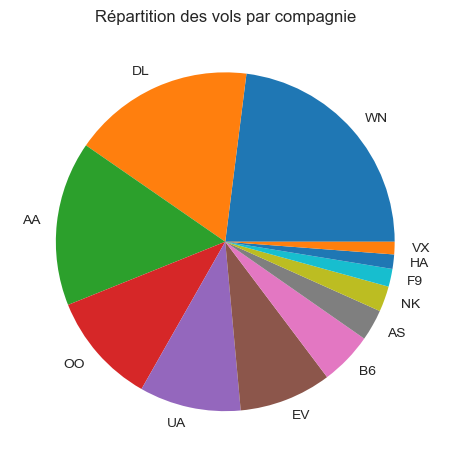

In [22]:
axes = df['UNIQUE_CARRIER'].value_counts().plot.pie();
axes.set_title('Répartition des vols par compagnie');
axes.set_ylabel('');

In [23]:
count = len(df['ORIGIN'].unique())
print(f"Nombre d'aéroports de départ : {count}")
count = len(df['DEST'].unique())
print(f"Nombre d'aéroports d'arrivée : {count}")

Nombre d'aéroports de départ : 311
Nombre d'aéroports d'arrivée : 310


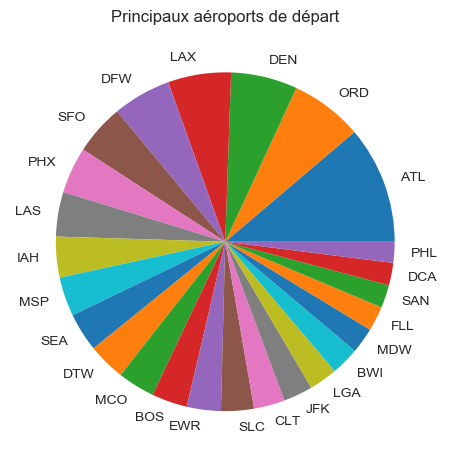

In [24]:
n = 25
axes = df['ORIGIN'].value_counts().head(n).plot.pie();
axes.set_title('Principaux aéroports de départ');
axes.set_ylabel('');

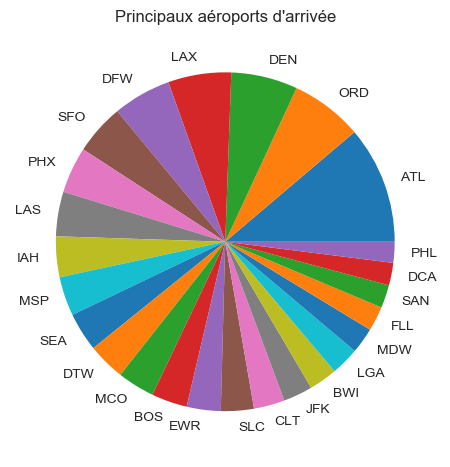

In [25]:
axes = df['DEST'].value_counts().head(n).plot.pie();
axes.set_title("Principaux aéroports d'arrivée");
axes.set_ylabel('');

On n'observe pas de différence notable entre les 2 listes : les aéroports les plus fréquentés le sont autant dans les deux sens.

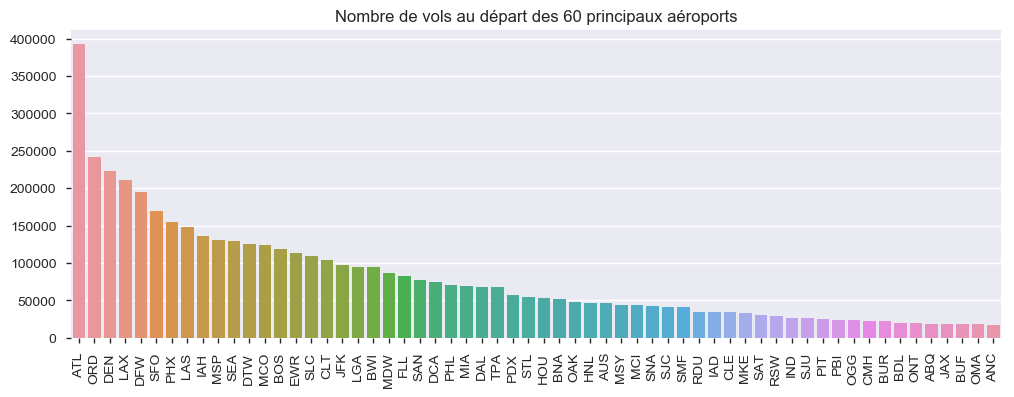

In [26]:
n = 60
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.set_color_codes("muted")
data = df['ORIGIN'].value_counts().head(60)
sns.barplot(x=data.index, y=data.values, ax=axes);
rotate_xlabels(axes)
axes.set_title(f"Nombre de vols au départ des {n} principaux aéroports");

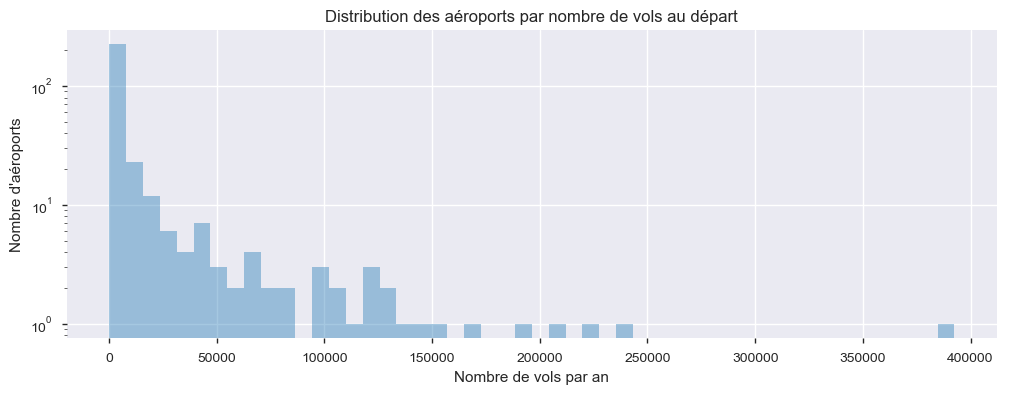

In [27]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.distplot(df['ORIGIN'].value_counts(), kde=False, ax=axes);
axes.set_yscale('log');
axes.set_title('Distribution des aéroports par nombre de vols au départ');
axes.set_xlabel('Nombre de vols par an');
axes.set_ylabel("Nombre d'aéroports");

### Distribution du délai

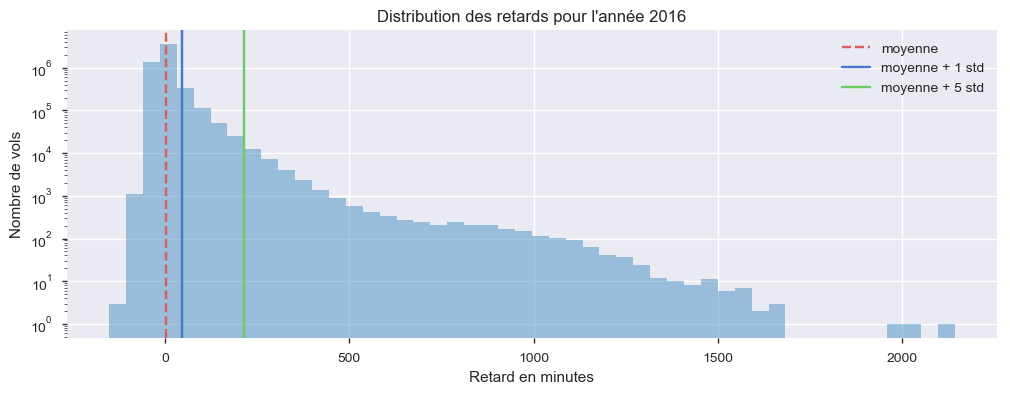

In [28]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.distplot(df['ARR_DELAY'], kde=False, ax=axes);
axes.set_yscale('log');
axes.set_xlabel('Retard en minutes');
axes.set_ylabel('Nombre de vols');
mean = df['ARR_DELAY'].mean()
median = df['ARR_DELAY'].median()
std = df['ARR_DELAY'].std()
axes.axvline(mean, color='r', linestyle='--', label='moyenne');
axes.axvline(mean+std, color='b', linestyle='-', label='moyenne + 1 std');
axes.axvline(mean + 5*std, color='g', linestyle='-', label='moyenne + 5 std');
axes.legend();
axes.set_title("Distribution des retards pour l'année 2016");

In [29]:
print(f"Nombre de vols en avance : {sum(df['ARR_DELAY'] < 0):>7}")
print(f"Nombre de vols à l'heure : {sum(df['ARR_DELAY'] == 0):>7}")
print(f"Nombre de vols en retard : {sum(df['ARR_DELAY'] > 0):>7}")

Nombre de vols en avance : 3549696
Nombre de vols à l'heure :  115988
Nombre de vols en retard : 1890513


### Évolution du délai au cours de l'année

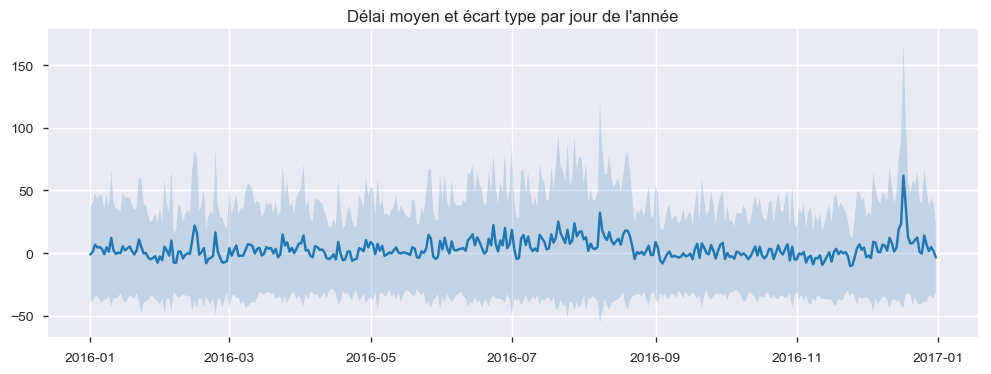

In [30]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['FL_DATE', 'ARR_DELAY']]
df1 = df1.groupby(['FL_DATE']).agg(['mean', 'std']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
sns.lineplot(data=df1, x='FL_DATE', y='ARR_DELAY_mean', ax=axes)
axes.fill_between(df1['FL_DATE'],
                  df1['ARR_DELAY_mean'] - df1['ARR_DELAY_std'],
                  df1['ARR_DELAY_mean'] + df1['ARR_DELAY_std'],
                  alpha=0.2);
axes.grid(True);
axes.set_title("Délai moyen et écart type par jour de l'année")
axes.set_xlabel("");
axes.set_ylabel("");

### Dix dates avec le plus grand retard moyen

In [31]:
df1 = df[['FL_DATE', 'ARR_DELAY']]
df1 = df1.groupby(['FL_DATE']).agg('mean').reset_index()
df1.nlargest(n=10, columns='ARR_DELAY')

,FL_DATE,ARR_DELAY
351,2016-12-17,61.890385
352,2016-12-18,38.007504
220,2016-08-08,32.192320
202,2016-07-21,25.144551
209,2016-07-28,23.844839
350,2016-12-16,23.326951
174,2016-06-23,22.367731
45,2016-02-15,21.974826
179,2016-06-28,20.117187
349,2016-12-15,19.307908


### Délai au départ en fonction de l'aéroport

Pour simplifier nous ne conservons que les principaux aéroports.

In [32]:
cutoff = 30000 if REMOVE_NEGATIVE_DELAYS else 50000
counts = df['ORIGIN'].value_counts()
mask = df['ORIGIN'].isin(counts[counts < cutoff].index)
df['ORIGIN_SHORT'] = df['ORIGIN'] # nouvelle colonne
df.loc[mask, 'ORIGIN_SHORT'] = 'Other'
df['ORIGIN_SHORT'].value_counts()

Other    1632741
ATL       392528
ORD       241352
DEN       222421
LAX       210635
DFW       194695
SFO       168920
PHX       154894
LAS       148578
IAH       136590
MSP       130844
SEA       129057
DTW       125108
MCO       124271
BOS       119095
EWR       113532
SLC       109799
CLT       103547
JFK        97844
LGA        94308
BWI        94222
MDW        85919
FLL        82463
SAN        76926
DCA        74891
PHL        69912
MIA        68692
DAL        67809
TPA        67379
PDX        57624
STL        55075
HOU        53435
BNA        51091
Name: ORIGIN_SHORT, dtype: int64

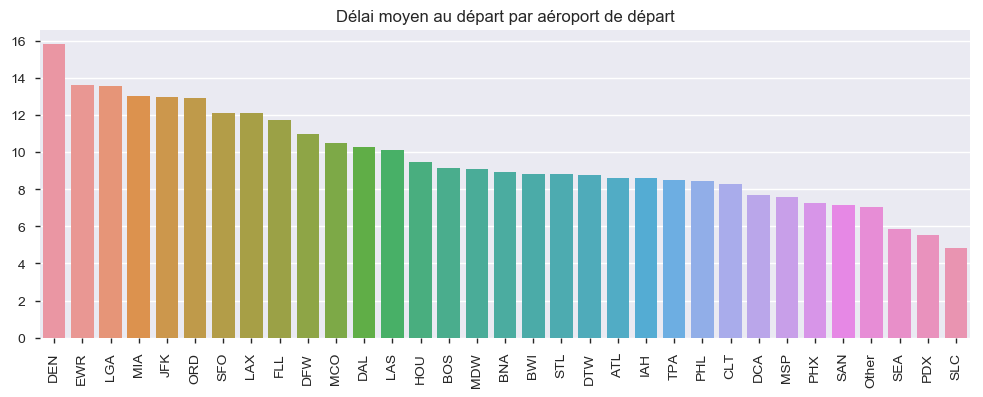

In [33]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['ORIGIN_SHORT', 'DEP_DELAY']]
df1 = df1.groupby(['ORIGIN_SHORT']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
df1.sort_values(by='DEP_DELAY_mean', ascending=False, inplace=True)
sns.barplot(data=df1, x='ORIGIN_SHORT', y='DEP_DELAY_mean', ax=axes);
axes.set_title('Délai moyen au départ par aéroport de départ');
axes.set_xlabel('');
axes.set_ylabel('');
rotate_xlabels(axes);

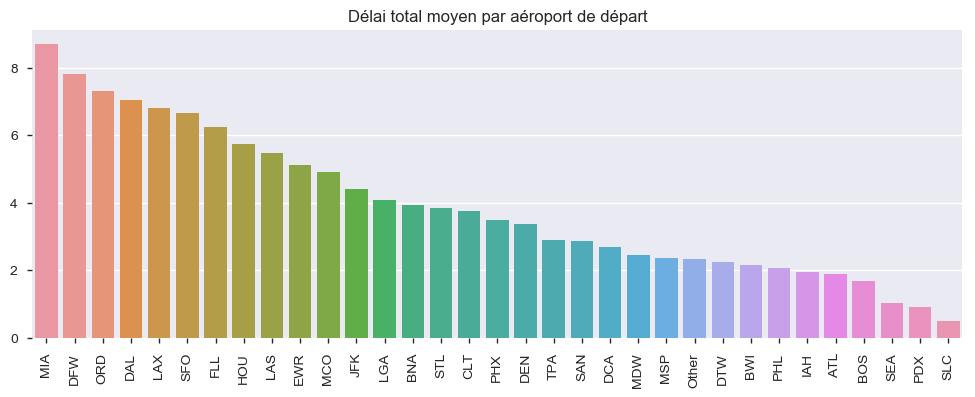

In [34]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['ORIGIN_SHORT', 'ARR_DELAY']]
df1 = df1.groupby(['ORIGIN_SHORT']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
df1.sort_values(by='ARR_DELAY_mean', ascending=False, inplace=True)
sns.barplot(data=df1, x='ORIGIN_SHORT', y='ARR_DELAY_mean', ax=axes);
axes.set_title('Délai total moyen par aéroport de départ');
axes.set_xlabel('');
axes.set_ylabel('');
rotate_xlabels(axes);

### Délai à l'arrivée en fonction de l'aéroport

#### Part du délai ayant eu lieu après le départ

In [35]:
df['PURE_ARR_DELAY'] = df['ARR_DELAY'] - df['DEP_DELAY']

In [36]:
cutoff = 40000 if REMOVE_NEGATIVE_DELAYS else 50000
counts = df['DEST'].value_counts()
mask = df['DEST'].isin(counts[counts < cutoff].index)
df['DEST_SHORT'] = df['DEST']
df.loc[mask, 'DEST_SHORT'] = 'Other'
df['DEST_SHORT'].value_counts()

Other    1634175
ATL       392199
ORD       240895
DEN       222152
LAX       210756
DFW       194260
SFO       168910
PHX       154435
LAS       148817
IAH       135956
MSP       130816
SEA       129119
DTW       125492
MCO       124302
BOS       119310
EWR       113527
SLC       109912
CLT       103237
JFK        97814
BWI        94398
LGA        94334
MDW        85897
FLL        82388
SAN        77009
DCA        75040
PHL        69859
MIA        68813
DAL        67722
TPA        67372
PDX        57654
STL        55083
HOU        53332
BNA        51212
Name: DEST_SHORT, dtype: int64

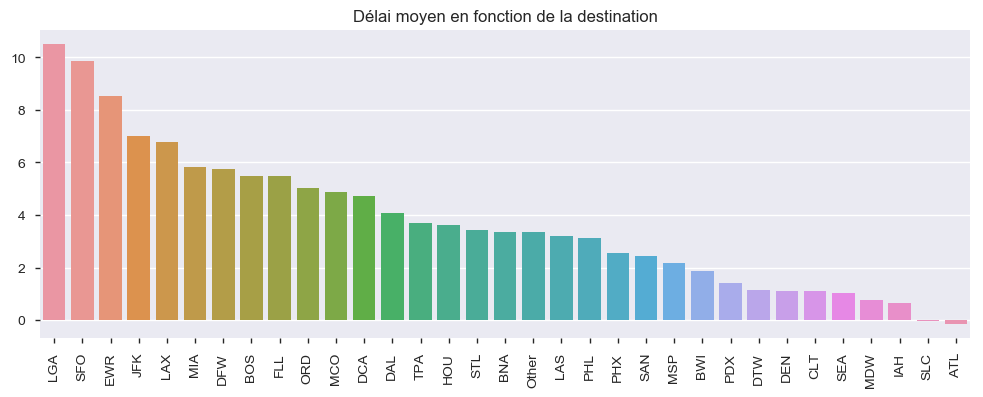

In [37]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['DEST_SHORT', 'ARR_DELAY']]
df1 = df1.groupby(['DEST_SHORT']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
df1.sort_values(by='ARR_DELAY_mean', ascending=False, inplace=True)
sns.barplot(data=df1, x='DEST_SHORT', y='ARR_DELAY_mean', ax=axes);
rotate_xlabels(axes);
axes.set_xlabel('');
axes.set_ylabel('');
axes.set_title('Délai moyen en fonction de la destination');

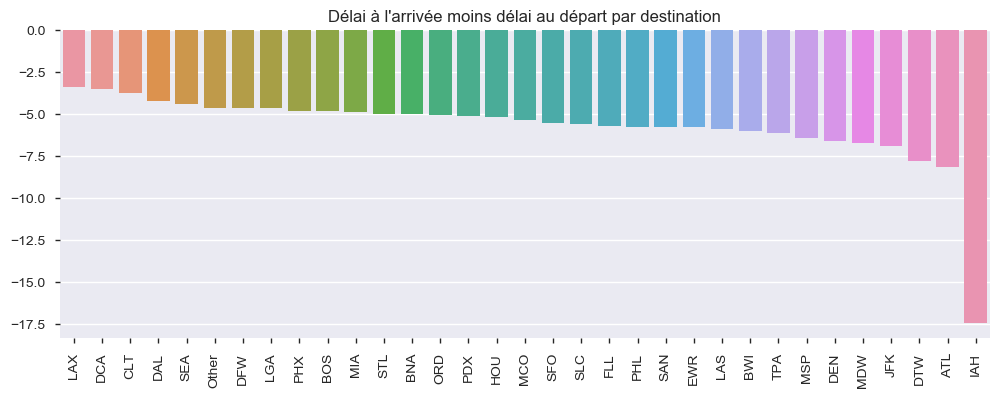

In [38]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['DEST_SHORT', 'PURE_ARR_DELAY']]
df1 = df1.groupby(['DEST_SHORT']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
df1.sort_values(by='PURE_ARR_DELAY_mean', ascending=False, inplace=True)
sns.barplot(data=df1, x='DEST_SHORT', y='PURE_ARR_DELAY_mean', ax=axes);
rotate_xlabels(axes);
axes.set_xlabel('');
axes.set_ylabel('');
axes.set_title("Délai à l'arrivée moins délai au départ par destination");

En moyenne les avions rattrapent un éventuel délai au départ lors du vol.

### Délai en fonction de la compagnie

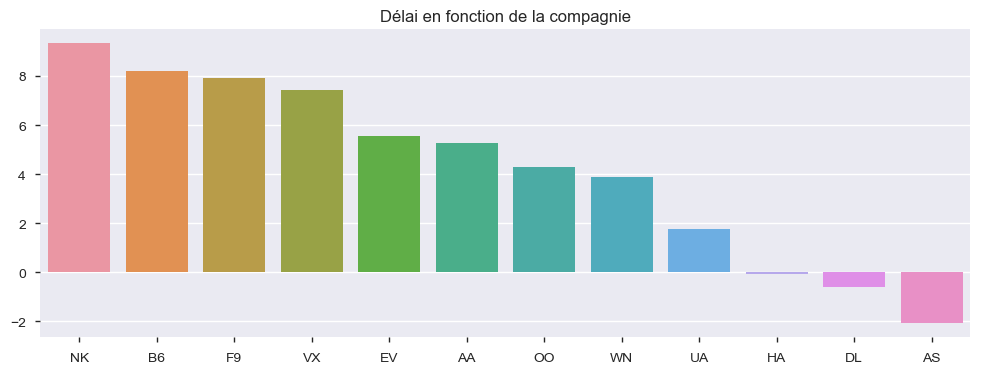

In [39]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['UNIQUE_CARRIER', 'ARR_DELAY']]
df1 = df1.groupby(['UNIQUE_CARRIER']).agg(['mean', 'std']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
df1.sort_values(by='ARR_DELAY_mean', ascending=False, inplace=True)
sns.barplot(data=df1, x='UNIQUE_CARRIER', y='ARR_DELAY_mean', ax=axes);
axes.set_xlabel('');
axes.set_ylabel('');
axes.set_title('Délai en fonction de la compagnie');

La compagnie aérienne semble avoir un impact plus important sur le retard que les aéroports. Nous inclurons donc cet attribut dans notre modèle, sous forme d'une colonne indicatrice par compagnie.

### Saisonnalité

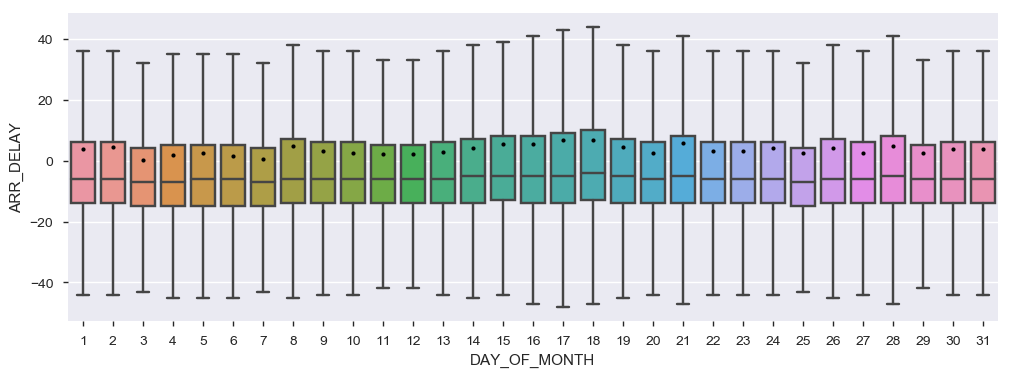

In [40]:
fig, axes = plt.subplots(figsize=(12, 4))
sns.boxplot(x='DAY_OF_MONTH',
            y='ARR_DELAY',
            data=df,
            showfliers=False,
            showmeans=True,
            meanprops=SNS_MEAN_MARKER);

La distribution n'est pas stationnaire, mais il est difficile de conclure.

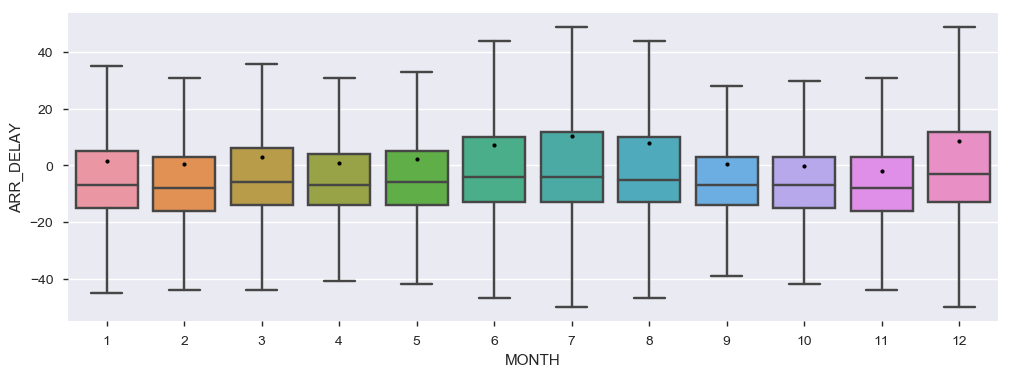

In [41]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.boxplot(x='MONTH',
            y='ARR_DELAY',
            data=df,
            showfliers=False,
            showmeans=True,
            meanprops=SNS_MEAN_MARKER);
# Les boîtes à moustaches sont plus lisibles que les diagrammes en violons

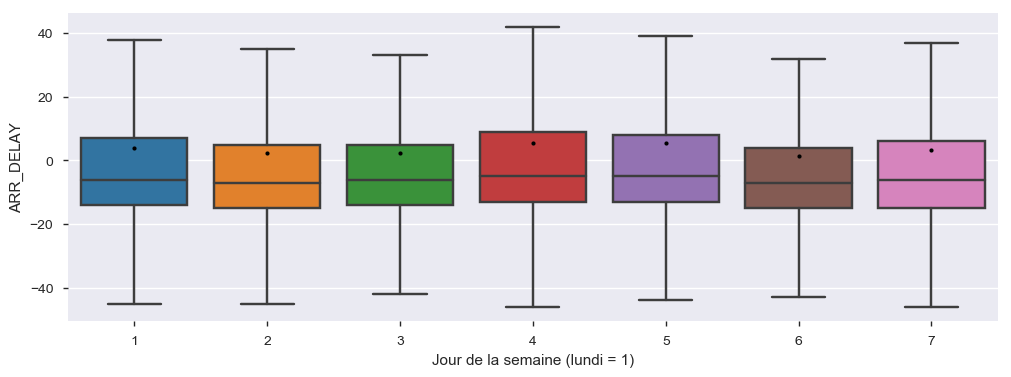

In [42]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.boxplot(x='DAY_OF_WEEK',
            y='ARR_DELAY',
            data=df,
            showfliers=False,
            showmeans=True,
            meanprops=SNS_MEAN_MARKER);
axes.set_xlabel('Jour de la semaine (lundi = 1)');

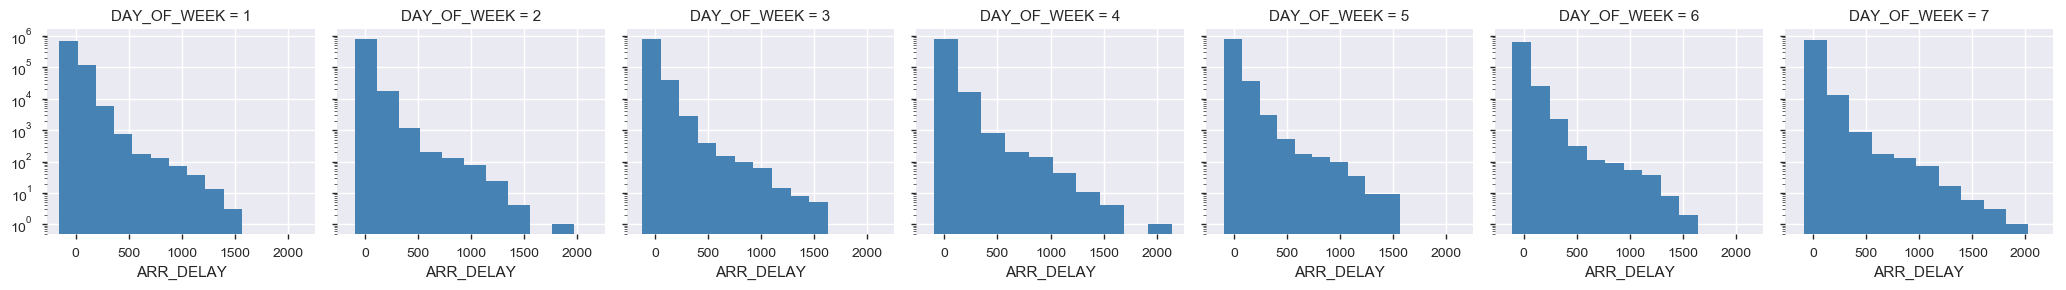

In [43]:
g = sns.FacetGrid(df, col="DAY_OF_WEEK", margin_titles=True)
g.map(plt.hist, "ARR_DELAY", color="steelblue").set(yscale='log');
# lundi = 1er jour

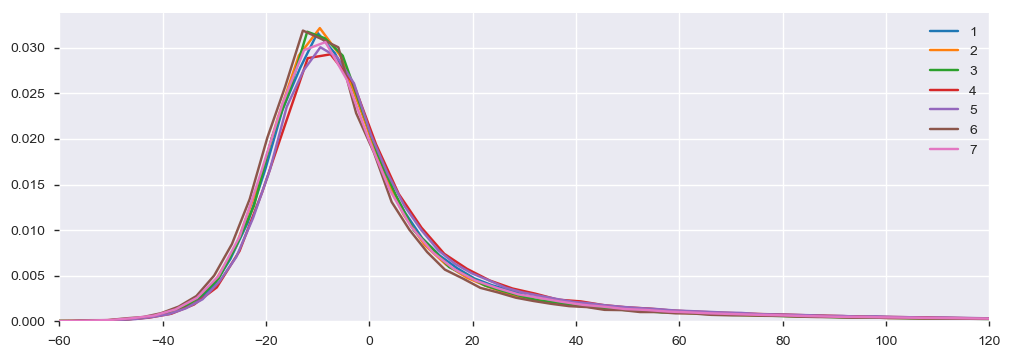

In [44]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
for day in range(1, 8):
    mask = (df['DAY_OF_WEEK'] == day)
    sns.kdeplot(df.loc[mask, 'ARR_DELAY'],
                gridsize=500,
                label=str(day),
                ax=axes)
axes.set_xlim(left=-60, right=120);

Ces courbes ne présentent pas suffisamment de différences pour que l'on puisse en tirer des conclusions.

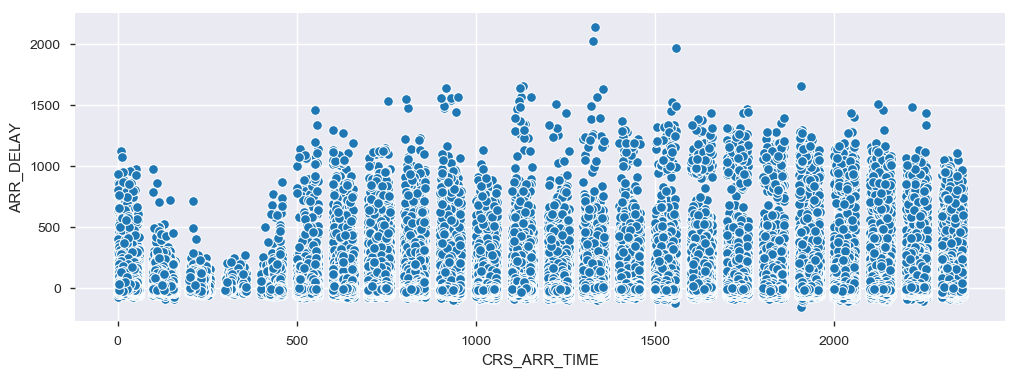

In [45]:
fig, axes = plt.subplots(figsize=(12, 4))
sns.scatterplot(x='CRS_ARR_TIME', y='ARR_DELAY', data=df);

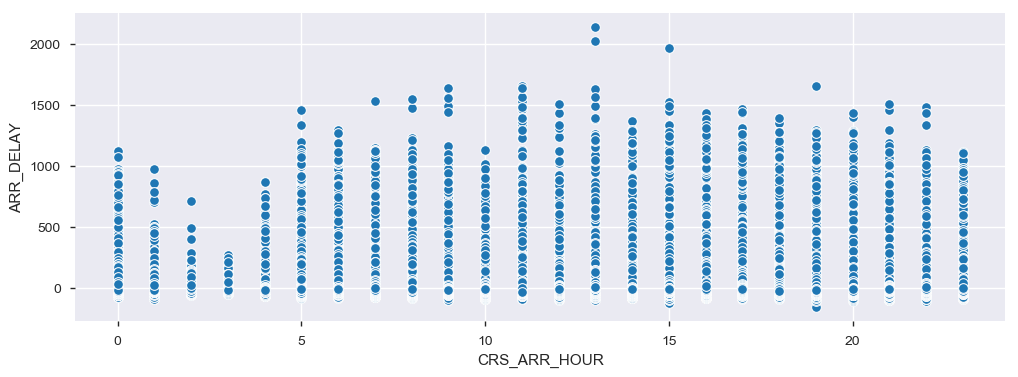

In [46]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df['CRS_ARR_HOUR'] = (df['CRS_ARR_TIME'] / 100).astype(int)
sns.scatterplot(x='CRS_ARR_HOUR', y='ARR_DELAY', data=df);

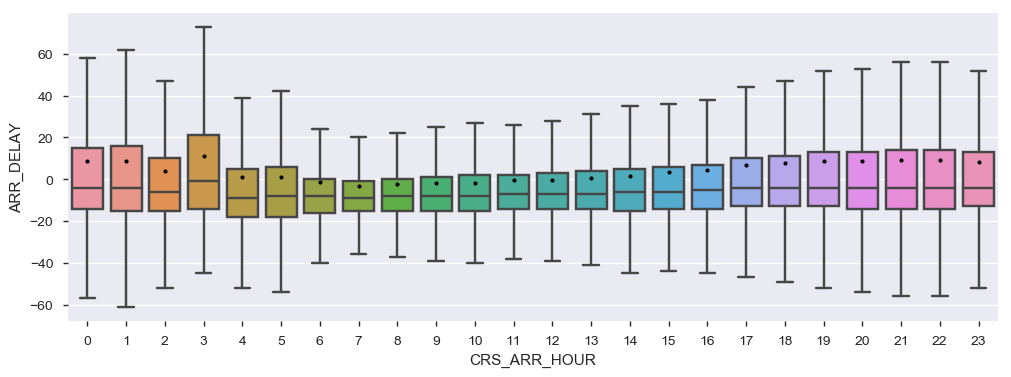

In [47]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.boxplot(x='CRS_ARR_HOUR',
            y='ARR_DELAY',
            data=df,
            ax=axes,            
            showfliers=False,
            showmeans=True,            
            meanprops=SNS_MEAN_MARKER);

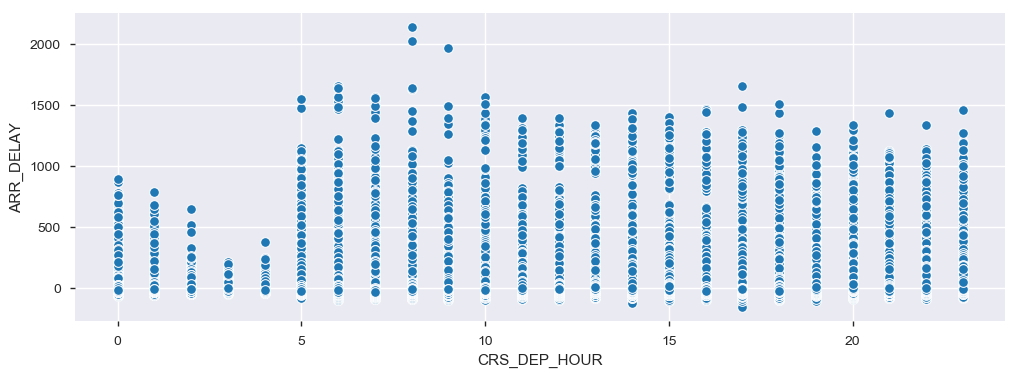

In [48]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df['CRS_DEP_HOUR'] = (df['CRS_DEP_TIME'] / 100).astype(int)
sns.scatterplot(x='CRS_DEP_HOUR', y='ARR_DELAY', data=df);

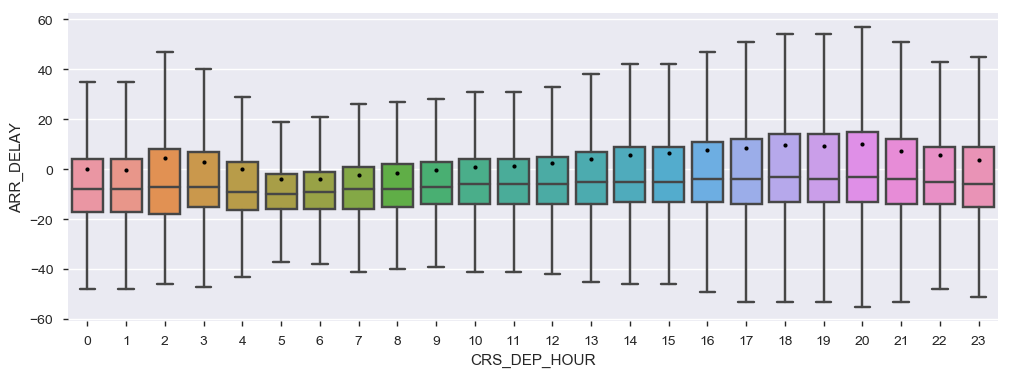

In [49]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.boxplot(x='CRS_DEP_HOUR',
            y='ARR_DELAY',
            data=df,
            ax=axes,            
            showfliers=False,
            showmeans=True,            
            meanprops=SNS_MEAN_MARKER);

## V. Enrichissement des données

### Calcul du score z (pour filtrage éventuel)

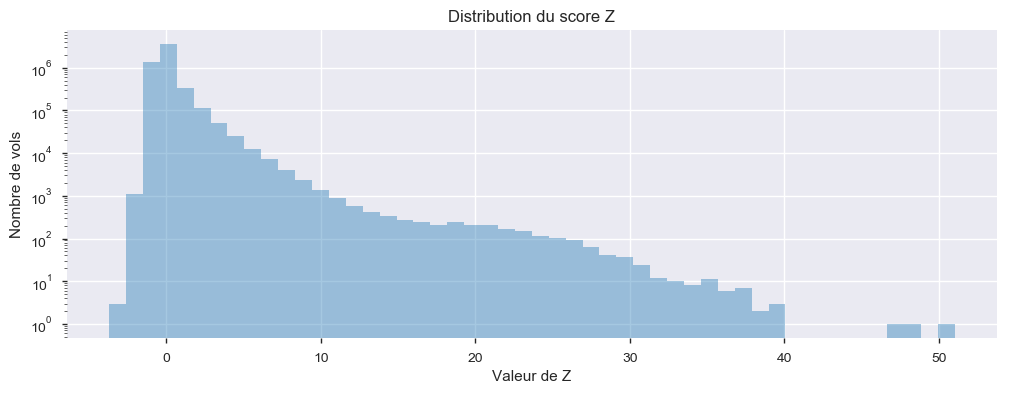

In [50]:
df['Z'] = stats.zscore(df['ARR_DELAY'])
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.distplot(df['Z'], kde=False, ax=axes);
axes.set_yscale('log');
axes.set_title('Distribution du score Z');
axes.set_xlabel('Valeur de Z');
axes.set_ylabel('Nombre de vols');

On retrouve la même forme de distribution que précédemment, car nous n'avons fait qu'appliquer une transformation linéaire.

### Distance aux week-ends et jours fériés

In [51]:
cal = USFederalHolidayCalendar()
hols = cal.holidays(start='2015-12-24', end='2017-01-02')

In [52]:
def hol_offset(d, fwd=True):
    """ Renvoie le nb de jours depuis ou jusqu'au jour férié suivant, ou 
    zéro si le jour `d` est un jour férié.
    """
    if fwd:
        # distance aux prochaines vacances
        delta = min(h - d for h in hols if h >= d)
    else:
        # distance aux dernières vacances
        delta = min(d - h for h in hols if h <= d)
    return delta.days


def we_offset(d):
    """ Renvoie le nb de jours jusqu'au week-end suivant, ou zéro
    si le jour est un samedi ou un dimanche.
    """
    return max(6 - d, 0)

# nouveau DataFrame pour stocker les dates
alldays = pd.DataFrame(df['FL_DATE'].unique(), columns=['FL_DATE'])
alldays.sort_values(by='FL_DATE', ascending=True)
# distance aux prochaines vacances
alldays['NEXT_HOL'] = alldays['FL_DATE'].apply(hol_offset)
# distance aux dernières vacances
alldays['PREV_HOL'] = alldays['FL_DATE'].apply(lambda d: hol_offset(d, False))
# distance au prochain week-end
alldays['DAY_OF_WEEK'] = alldays['FL_DATE'].dt.weekday + 1
alldays['NEXT_WE'] = alldays['DAY_OF_WEEK'].apply(we_offset)
alldays.drop(columns='DAY_OF_WEEK', inplace=True, errors='ignore')
alldays.head()

,FL_DATE,NEXT_HOL,PREV_HOL,NEXT_WE
0,2016-01-06,12,5,3
1,2016-01-07,11,6,2
2,2016-01-08,10,7,1
3,2016-01-09,9,8,0
4,2016-01-10,8,9,0


In [53]:
df = df.merge(alldays, on='FL_DATE', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556197 entries, 0 to 5556196
Data columns (total 25 columns):
QUARTER             int32
MONTH               int32
DAY_OF_MONTH        int32
DAY_OF_WEEK         int32
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
FL_NUM              float64
ORIGIN              object
ORIGIN_STATE_ABR    object
DEST                object
DEST_STATE_ABR      object
CRS_DEP_TIME        int32
DEP_DELAY           int32
CRS_ARR_TIME        int32
ARR_DELAY           int32
CRS_ELAPSED_TIME    int32
ORIGIN_SHORT        object
PURE_ARR_DELAY      int32
DEST_SHORT          object
CRS_ARR_HOUR        int32
CRS_DEP_HOUR        int32
Z                   float64
NEXT_HOL            int64
PREV_HOL            int64
NEXT_WE             int64
dtypes: datetime64[ns](1), float64(2), int32(12), int64(3), object(7)
memory usage: 847.8+ MB


In [54]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_STATE_ABR,DEST,...,CRS_ELAPSED_TIME,ORIGIN_SHORT,PURE_ARR_DELAY,DEST_SHORT,CRS_ARR_HOUR,CRS_DEP_HOUR,Z,NEXT_HOL,PREV_HOL,NEXT_WE
0,1,1,6,3,2016-01-06,AA,43.0,DFW,TX,DTW,...,158,DFW,-3,DTW,14,11,-0.227477,12,5,3
1,1,1,7,4,2016-01-07,AA,43.0,DFW,TX,DTW,...,158,DFW,-8,DTW,14,11,-0.370599,11,6,2
2,1,1,8,5,2016-01-08,AA,43.0,DFW,TX,DTW,...,158,DFW,12,DTW,14,11,0.082619,10,7,1
3,1,1,9,6,2016-01-09,AA,43.0,DFW,TX,DTW,...,158,DFW,-7,DTW,14,11,-0.203624,9,8,0
4,1,1,10,7,2016-01-10,AA,43.0,DFW,TX,DTW,...,158,DFW,13,DTW,14,11,2.611097,8,9,0


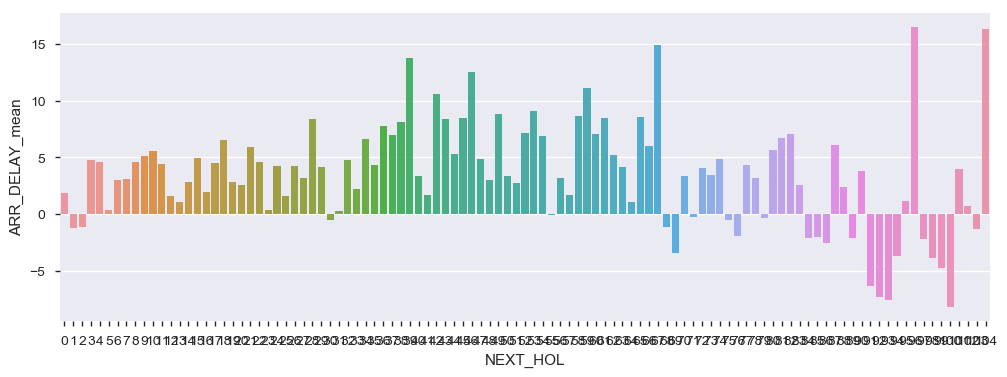

In [55]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['NEXT_HOL', 'ARR_DELAY']]
df1 = df1.groupby(['NEXT_HOL']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
sns.barplot(data=df1, x='NEXT_HOL', y='ARR_DELAY_mean');

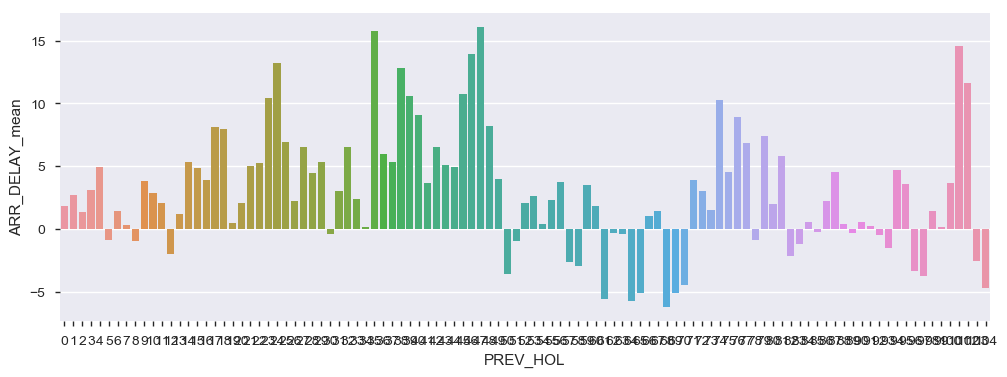

In [56]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
df1 = df[['PREV_HOL', 'ARR_DELAY']]
df1 = df1.groupby(['PREV_HOL']).agg(['mean']).reset_index()
df1.columns = ['_'.join(col).rstrip('_') for col in df1.columns.values]
sns.barplot(data=df1, x='PREV_HOL', y='ARR_DELAY_mean');

On ne peut rien conclure de ces 2 diagrammes.

### Observations
- Un modèle linéaire ne pourra pas modéliser la saisonnalité.
- Nous n'avons pas pris en compte les vacances scolaires.
- Le retard au départ est la principale composante du retard total : à approfondir.
- Nous pourrions également étudier le retard en fonction de la paire (origine, destination).

## VI. Prise en compte des performances de l'année précédente

### Chargement des données de T-1

In [57]:
files = [f"transtats/2015_{m:02}_short.csv" for m in range(1, 13)]
cols = [
    'FL_DATE', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY'
]
hist_df = pd.concat((pd.read_csv(f, usecols=cols) for f in files),
                    ignore_index=True)
hist_df['FL_DATE'] = pd.to_datetime(hist_df['FL_DATE'],
                                    format='%Y-%m-%d',
                                    errors='coerce')
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 6 columns):
FL_DATE           datetime64[ns]
UNIQUE_CARRIER    object
ORIGIN            object
DEST              object
DEP_DELAY         float64
ARR_DELAY         float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 266.4+ MB


In [58]:
# Vérifions que nous avons toutes les données
print(f"Liste des mois chargés : {hist_df['FL_DATE'].dt.month.unique()}")

Liste des mois chargés : [ 1  2  3  4  5  6  7  8  9 10 11 12]


### Nettoyage

In [59]:
na_count = hist_df.isna().sum(axis=0)
num_nas = na_count.sum()
print(f"Nombre de valeurs manquantes : {num_nas} "
      f"({num_nas / len(hist_df) * 100:0.2f} %)")
print(f"Taille des données : {hist_df.shape}")
hist_df.dropna(axis=0, how='any', inplace=True)
print(f"Nouvelle taille des données : {hist_df.shape}")

Nombre de valeurs manquantes : 191224 (3.29 %)
Taille des données : (5819079, 6)
Nouvelle taille des données : (5714008, 6)


### Comparaison des retards les années T et T-1

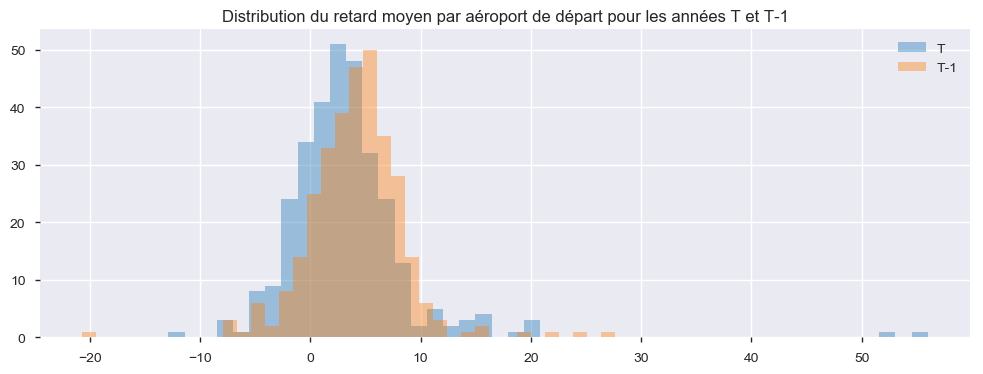

In [60]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
delays = df.groupby(['ORIGIN'])['ARR_DELAY'].agg('mean').reset_index()
sns.distplot(delays['ARR_DELAY'], kde=False, ax=axes, label='T');
delays = hist_df.groupby(['ORIGIN'])['ARR_DELAY'].agg('mean').reset_index()
sns.distplot(delays['ARR_DELAY'], kde=False, ax=axes, label='T-1')
axes.legend();
axes.set_xlabel('')
axes.set_title("Distribution du retard moyen "
               "par aéroport de départ pour les années T et T-1");

Les deux distributions sont très proches : utiliser le retard par aéroport calculé à partir des donnée de l'année précédente devrait devrait donc augmenter notre pouvoir prédictif.

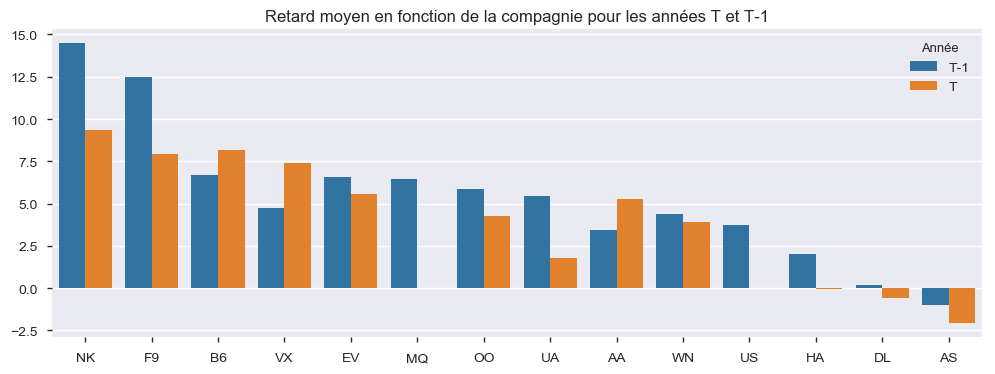

In [61]:
fig, axes = plt.subplots(figsize=FIG_SIZE)
delays_by_co = hist_df[['UNIQUE_CARRIER', 'ARR_DELAY']]
delays_by_co = delays_by_co.groupby(['UNIQUE_CARRIER']).agg('mean').reset_index()
delays_by_co['Année'] = 'T-1'
df1 = df[['UNIQUE_CARRIER', 'ARR_DELAY']]
df1 = df1.groupby(['UNIQUE_CARRIER']).agg('mean').reset_index()
df1['Année'] = 'T'
df1 = df1.append(delays_by_co)
df1.sort_values(by='ARR_DELAY', ascending=False, inplace=True)
sns.barplot(data=df1, x='UNIQUE_CARRIER', y='ARR_DELAY', hue='Année', ax=axes);
axes.set_xlabel('');
axes.set_ylabel('');
axes.set_title('Retard moyen en fonction de la compagnie pour les années T et T-1');

Même conclusion pour le retard par compagnie : il reste relativement stable de T-1 à T et devrait donc améliorer la performance du modèle.

### Ajout du retard moyen à T-1 par aéroport de départ et par compagnie aux données

In [62]:
delays_by_co.rename(columns={'ARR_DELAY': 'CARRIER_DELAY'}, inplace=True)
delays_by_co.drop(columns='Année', inplace=True, errors='ignore')
delays_by_co = delays_by_co.reset_index().set_index('UNIQUE_CARRIER')
delays_by_co.drop(columns='index', inplace=True)
df = df.join(delays_by_co, on='UNIQUE_CARRIER')
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5556197, 26)


In [63]:
delays.rename(columns={'ARR_DELAY': 'ORIGIN_DELAY'}, inplace=True)
delays = delays.reset_index().set_index('ORIGIN')
delays.drop(columns='index', inplace=True)
df = df.join(delays, on='ORIGIN')
print(f"Nouvelle taille des données : {df.shape}")

Nouvelle taille des données : (5556197, 27)


In [64]:
print(f"Nombre de valeurs manquantes : {df['ORIGIN_DELAY'].isnull().sum()}")
df['ORIGIN_DELAY'].fillna(df['ORIGIN_DELAY'].mean(), inplace=True)      
print(f"Nombre de valeurs manquantes totales après correction : "
      f"{df.isnull().sum().sum()}")

Nombre de valeurs manquantes : 80
Nombre de valeurs manquantes totales après correction : 0


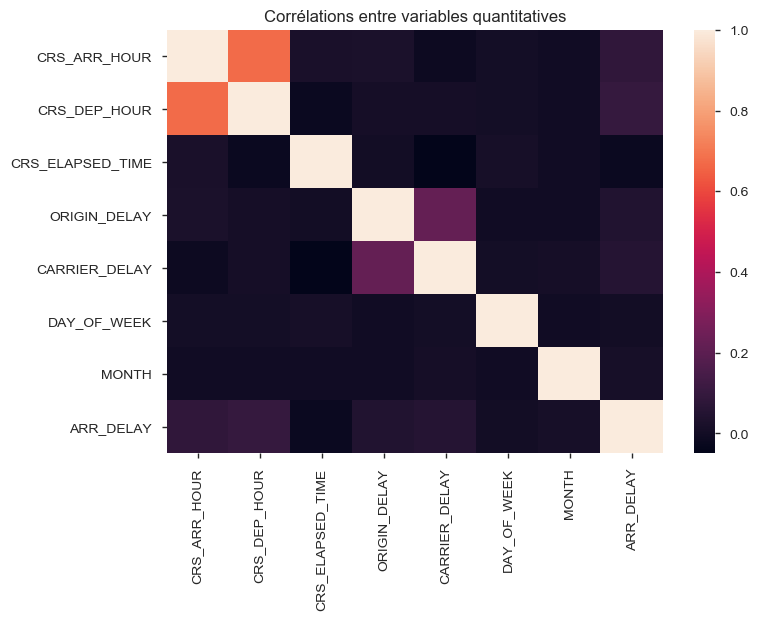

In [65]:
fig, axes = plt.subplots()
columns = [
    'CRS_ARR_HOUR', 'CRS_DEP_HOUR', 'CRS_ELAPSED_TIME', 'ORIGIN_DELAY',
    'CARRIER_DELAY', 'DAY_OF_WEEK', 'MONTH', 'ARR_DELAY'
]
df1 = df[columns]
corr = df1.corr()
sns.heatmap(corr, ax=axes)
axes.set_title('Corrélations entre variables quantitatives');

L'absence de corrélation significative entre le délai et les autres variables devrait-elle nous inquiéter ?

## VII. Sauvegarde des données

In [66]:
if EXPORT_DATA:
    # Suppression des colonnes inutiles
    df.drop(columns=[
        'ORIGIN_SHORT', 'DEST_SHORT', 'FL_NUM',
        'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'PURE_ARR_DELAY', 'QUARTER',
        'DAY_OF_MONTH', 'FL_NUM', 'NEXT_WE'
    ],
            inplace=True,
            errors='ignore')
    df.to_csv(OUTPUT_FILE, sep='\t')
    print(f"Taille du tableau sauvegardé : {df.shape}")
    size = os.path.getsize(OUTPUT_FILE) / 1024 / 1024
    print(f"Taille du fichier : {size:0.1f} Mo")
else:
    print("Export des données désactivé.")

Taille du tableau sauvegardé : (5556197, 18)
Taille du fichier : 649.7 Mo


In [67]:
df.head()

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,CRS_ARR_HOUR,CRS_DEP_HOUR,Z,NEXT_HOL,PREV_HOL,CARRIER_DELAY,ORIGIN_DELAY
0,1,3,2016-01-06,AA,DFW,DTW,1100,-3,1438,-6,158,14,11,-0.227477,12,5,3.451372,6.416853
1,1,4,2016-01-07,AA,DFW,DTW,1100,-4,1438,-12,158,14,11,-0.370599,11,6,3.451372,6.416853
2,1,5,2016-01-08,AA,DFW,DTW,1100,-5,1438,7,158,14,11,0.082619,10,7,3.451372,6.416853
3,1,6,2016-01-09,AA,DFW,DTW,1100,2,1438,-5,158,14,11,-0.203624,9,8,3.451372,6.416853
4,1,7,2016-01-10,AA,DFW,DTW,1100,100,1438,113,158,14,11,2.611097,8,9,3.451372,6.416853


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556197 entries, 0 to 5556196
Data columns (total 18 columns):
MONTH               int32
DAY_OF_WEEK         int32
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
ORIGIN              object
DEST                object
CRS_DEP_TIME        int32
DEP_DELAY           int32
CRS_ARR_TIME        int32
ARR_DELAY           int32
CRS_ELAPSED_TIME    int32
CRS_ARR_HOUR        int32
CRS_DEP_HOUR        int32
Z                   float64
NEXT_HOL            int64
PREV_HOL            int64
CARRIER_DELAY       float64
ORIGIN_DELAY        float64
dtypes: datetime64[ns](1), float64(3), int32(9), int64(2), object(3)
memory usage: 774.7+ MB


In [69]:
# Listes statiques
airlines = [
    'AA', 'AS', 'B6', 'DL', 'F9', 'HA', 'NK', 'EV', 'OO', 'UA', 'VX', 'WN'
]
airports = [
    'ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK',
    'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'AMA', 'ANC', 'APN', 'ASE', 'ATL',
    'ATW', 'AUS', 'AVL', 'AVP', 'AZO', 'BDL', 'BET', 'BFL', 'BGM', 'BGR',
    'BHM', 'BIL', 'BIS', 'BJI', 'BLI', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT',
    'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR',
    'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CHA', 'CHO', 'CHS', 'CID',
    'CIU', 'CLE', 'CLL', 'CLT', 'CMH', 'CMX', 'COD', 'COS', 'CPR', 'CRP',
    'CRW', 'CSG', 'CVG', 'CWA', 'DAB', 'DAL', 'DAY', 'DCA', 'DEN', 'DFW',
    'DHN', 'DLG', 'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAU', 'ECP', 'EFD',
    'EGE', 'EKO', 'ELM', 'ELP', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR',
    'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FSD',
    'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT',
    'GRB', 'GRI', 'GRK', 'GRR', 'GSO', 'GSP', 'GST', 'GTF', 'GTR', 'GUC',
    'GUM', 'HDN', 'HIB', 'HLN', 'HNL', 'HOB', 'HOU', 'HPN', 'HRL', 'HSV',
    'HYA', 'HYS', 'IAD', 'IAG', 'IAH', 'ICT', 'IDA', 'ILM', 'IMT', 'IND',
    'INL', 'ISN', 'ISP', 'ITH', 'ITO', 'JAC', 'JAN', 'JAX', 'JFK', 'JLN',
    'JMS', 'JNU', 'KOA', 'KTN', 'LAN', 'LAR', 'LAS', 'LAW', 'LAX', 'LBB',
    'LBE', 'LCH', 'LEX', 'LFT', 'LGA', 'LGB', 'LIH', 'LIT', 'LNK', 'LRD',
    'LSE', 'LWS', 'MAF', 'MBS', 'MCI', 'MCO', 'MDT', 'MDW', 'MEI', 'MEM',
    'MFE', 'MFR', 'MGM', 'MHK', 'MHT', 'MIA', 'MKE', 'MKG', 'MLB', 'MLI',
    'MLU', 'MMH', 'MOB', 'MOT', 'MQT', 'MRY', 'MSN', 'MSO', 'MSP', 'MSY',
    'MTJ', 'MVY', 'MYR', 'OAJ', 'OAK', 'OGG', 'OKC', 'OMA', 'OME', 'ONT',
    'ORD', 'ORF', 'ORH', 'OTH', 'OTZ', 'PAH', 'PBG', 'PBI', 'PDX', 'PGD',
    'PHF', 'PHL', 'PHX', 'PIA', 'PIB', 'PIH', 'PIT', 'PLN', 'PNS', 'PPG',
    'PSC', 'PSE', 'PSG', 'PSP', 'PVD', 'PWM', 'RAP', 'RDD', 'RDM', 'RDU',
    'RHI', 'RIC', 'RKS', 'RNO', 'ROA', 'ROC', 'ROW', 'RST', 'RSW', 'SAF',
    'SAN', 'SAT', 'SAV', 'SBA', 'SBN', 'SBP', 'SCC', 'SCE', 'SDF', 'SEA',
    'SFO', 'SGF', 'SGU', 'SHV', 'SIT', 'SJC', 'SJT', 'SJU', 'SLC', 'SMF',
    'SMX', 'SNA', 'SPI', 'SPN', 'SPS', 'SRQ', 'STL', 'STT', 'STX', 'SUN',
    'SWF', 'SYR', 'TLH', 'TPA', 'TRI', 'TTN', 'TUL', 'TUS', 'TVC', 'TWF',
    'TXK', 'TYR', 'TYS', 'UST', 'VLD', 'VPS', 'WRG', 'WYS', 'XNA', 'YAK', 'YUM'
]